<a href="https://colab.research.google.com/github/kohgeonbu/kohgeonbu/blob/main/mimii_final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

function ClickConnect(){
  colab.config
  console.log("Connnect Clicked - Start");
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End");
};
setInterval(ClickConnect, 60000)

In [ ]:
# === [1] Google Drive mount & Directory Setup ===

IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except:
    pass

from pathlib import Path
import shutil

# ========== Google Drive 마운트 ==========
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    BASE = Path('/content/drive/MyDrive')
else:
    BASE = Path('.')

print("="*60)
print("🎯 MIMII Anomaly Detection - Percentile Only Version")
print("="*60)

# ========== 필요한 디렉토리 정의 ==========
DATASET_NAME = "fan"

# 주요 경로들
DATA_ROOT = BASE / "grad_project" / "mimii_dataset" / DATASET_NAME
OUTPUT_DIR = BASE / "grad_project" / "output_percentile" / DATASET_NAME
FEATURE_CACHE_DIR = DATA_ROOT / "features_cache_final"
SPLIT_DIR = DATA_ROOT / "splits"

# ========== 디렉토리 생성 ==========
print("\n[Directory Setup]")

directories = {
    "Data Root": DATA_ROOT,
    "Output": OUTPUT_DIR,
    "Feature Cache": FEATURE_CACHE_DIR,
    "Split": SPLIT_DIR
}

for name, path in directories.items():
    if path.exists():
        print(f"  ✅ {name:15s}: {path} (exists)")
    else:
        try:
            path.mkdir(parents=True, exist_ok=True)
            print(f"  ✅ {name:15s}: {path} (created)")
        except Exception as e:
            print(f"  ❌ {name:15s}: Failed to create - {e}")

print("\n[Paths]")
print(f"  BASE:              {BASE}")
print(f"  DATA_ROOT:         {DATA_ROOT}")
print(f"  OUTPUT_DIR:        {OUTPUT_DIR}")
print(f"  FEATURE_CACHE_DIR: {FEATURE_CACHE_DIR}")
print(f"  SPLIT_DIR:         {SPLIT_DIR}")

print("\n[Required Files Check]")
split_files = {
    "train_normal.txt": SPLIT_DIR / "train_normal.txt",
    "val_normal.txt": SPLIT_DIR / "val_normal.txt",
    "test_normal.txt": SPLIT_DIR / "test_normal.txt",
    "test_abnormal.txt": SPLIT_DIR / "test_abnormal.txt"
}

all_exist = True
for name, path in split_files.items():
    if path.exists():
        print(f"  ✅ {name:20s}: exists")
    else:
        print(f"  ❌ {name:20s}: NOT FOUND!")
        all_exist = False

if not all_exist:
    print(f"\n⚠️ WARNING: Some split files are missing!")
    print(f"   Please run data split first or check SPLIT_DIR: {SPLIT_DIR}")

print("="*60)

Mounted at /content/drive
🎯 MIMII Anomaly Detection - Percentile Only Version

[Directory Setup]
  ✅ Data Root      : /content/drive/MyDrive/grad_project/mimii_dataset/fan (exists)
  ✅ Output         : /content/drive/MyDrive/grad_project/output_percentile/fan (created)
  ✅ Feature Cache  : /content/drive/MyDrive/grad_project/mimii_dataset/fan/features_cache_final (exists)
  ✅ Split          : /content/drive/MyDrive/grad_project/mimii_dataset/fan/splits (exists)

[Paths]
  BASE:              /content/drive/MyDrive
  DATA_ROOT:         /content/drive/MyDrive/grad_project/mimii_dataset/fan
  OUTPUT_DIR:        /content/drive/MyDrive/grad_project/output_percentile/fan
  FEATURE_CACHE_DIR: /content/drive/MyDrive/grad_project/mimii_dataset/fan/features_cache_final
  SPLIT_DIR:         /content/drive/MyDrive/grad_project/mimii_dataset/fan/splits

[Required Files Check]
  ✅ train_normal.txt    : exists
  ✅ val_normal.txt      : exists
  ✅ test_normal.txt     : exists
  ✅ test_abnormal.txt   : 

In [ ]:
# === [2] Cache Copy (Conditional) ===

print("\n" + "="*60)
print("📦 CACHE MANAGEMENT")
print("="*60)

OLD_CACHE = DATA_ROOT / "features_cache"
NEW_CACHE = FEATURE_CACHE_DIR

def get_dir_size(path):
    total = 0
    for entry in path.rglob('*'):
        if entry.is_file():
            total += entry.stat().st_size
    return total

if NEW_CACHE.exists():
    cache_files = list(NEW_CACHE.rglob("*.npy"))
    print(f"✅ Cache already exists: {len(cache_files)} files")
    print(f"   Location: {NEW_CACHE}")

    size_mb = get_dir_size(NEW_CACHE) / 1024 / 1024
    print(f"   Size: {size_mb:.2f} MB")
    print("   Skipping copy...")

elif OLD_CACHE.exists():
    print(f"📦 Copying cache from {OLD_CACHE}")
    print(f"   to {NEW_CACHE}")
    print("   This may take a few minutes...")

    try:
        shutil.copytree(OLD_CACHE, NEW_CACHE)
        cache_files = list(NEW_CACHE.rglob("*.npy"))
        size_mb = get_dir_size(NEW_CACHE) / 1024 / 1024
        print(f"✅ Cache copied successfully!")
        print(f"   Files: {len(cache_files)}")
        print(f"   Size: {size_mb:.2f} MB")
    except Exception as e:
        print(f"⚠️ Cache copy failed: {e}")
        print("   Will extract features from scratch...")
        NEW_CACHE.mkdir(parents=True, exist_ok=True)
else:
    print("⚠️ Old cache not found")
    print("   Will extract features from scratch...")
    NEW_CACHE.mkdir(parents=True, exist_ok=True)


📦 CACHE MANAGEMENT
✅ Cache already exists: 16313 files
   Location: /content/drive/MyDrive/grad_project/mimii_dataset/fan/features_cache_final
   Size: 6.25 MB
   Skipping copy...


In [ ]:
# === [3] Package Import & Configuration ===

import sys
if IN_COLAB:
    import subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q",
                    "librosa", "soundfile", "tqdm", "scikit-learn", "matplotlib", "seaborn"])

import os
import json
import pickle
import warnings
import numpy as np
import soundfile as sf
import librosa
from tqdm import tqdm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

set_seed(42)

CONFIG = {
    "SR": 16000,
    "N_FFT": 1024,
    "HOP": 512,
    "N_MELS": 128,
    "FMIN": 50,
    "FMAX": 8000,
    "N_NEIGHBORS": 20,
    "CONTAMINATION": 0.1,
}

print("\n" + "="*60)
print("⚙️ CONFIGURATION")
print("="*60)
print(f"Model: LOF (Local Outlier Factor)")
print(f"n_neighbors: {CONFIG['N_NEIGHBORS']}")
print(f"contamination: {CONFIG['CONTAMINATION']}")
print(f"⭐ Threshold Method: Percentile-based (Normal data only)")
print("="*60)


⚙️ CONFIGURATION
Model: LOF (Local Outlier Factor)
n_neighbors: 20
contamination: 0.1
⭐ Threshold Method: Percentile-based (Normal data only)


In [ ]:
# === [4] Load Data Split ===

print("\n" + "="*60)
print("📂 LOADING DATA SPLIT")
print("="*60)

def load_split_files():
    """데이터 분할 파일 로드"""
    split_files = {
        "train": SPLIT_DIR / "train_normal.txt",
        "val": SPLIT_DIR / "val_normal.txt",
        "test_norm": SPLIT_DIR / "test_normal.txt",
        "test_abn": SPLIT_DIR / "test_abnormal.txt",
    }

    if not all(p.exists() for p in split_files.values()):
        raise FileNotFoundError(f"Split files not found in {SPLIT_DIR}")

    data = {}
    for key, path in split_files.items():
        with open(path, 'r') as f:
            data[key] = [line.strip() for line in f if line.strip()]

    return data

data = load_split_files()

print(f"[Data Split]")
print(f"  Train:        {len(data['train'])} (normal only)")
print(f"  Validation:   {len(data['val'])} (normal only)")
print(f"  Test Normal:  {len(data['test_norm'])}")
print(f"  Test Abnormal:{len(data['test_abn'])}")
print(f"\n✅ Total samples: {sum(len(v) for v in data.values())}")


📂 LOADING DATA SPLIT
[Data Split]
  Train:        7847 (normal only)
  Validation:   1123 (normal only)
  Test Normal:  2246
  Test Abnormal:4064

✅ Total samples: 15280


In [ ]:
# === [5] Feature Extraction Functions ===

def get_cache_path(wav_path):
    """캐시 파일 경로 생성"""
    stem = Path(wav_path).stem
    rel_path = Path(wav_path).relative_to(DATA_ROOT)
    cache_subdir = FEATURE_CACHE_DIR / rel_path.parent
    cache_subdir.mkdir(parents=True, exist_ok=True)
    return cache_subdir / f"{stem}_feat.npy"

def extract_features(wav_path, use_cache=True):
    """
    통계 기반 특징 추출 (65개)
    """
    cache_path = get_cache_path(wav_path)

    # 캐시 확인
    if use_cache and cache_path.exists():
        try:
            return np.load(cache_path)
        except:
            pass

    try:
        # 오디오 로드
        y, sr = sf.read(wav_path, dtype='float32')
        if y.ndim > 1:
            y = y.mean(axis=1)
        if sr != CONFIG["SR"]:
            y = librosa.resample(y=y, orig_sr=sr, target_sr=CONFIG["SR"])

        features = []

        # 1) 시간 도메인 (3개)
        features.extend([
            float(np.sqrt(np.mean(y**2))),  # RMS
            float(np.mean(librosa.zero_crossings(y))),  # ZCR
            float(np.sum(y**2))  # Energy
        ])

        # 2) Spectral (10개)
        S = np.abs(librosa.stft(y, n_fft=CONFIG["N_FFT"], hop_length=CONFIG["HOP"]))

        spec_centroid = librosa.feature.spectral_centroid(S=S, sr=CONFIG["SR"])
        spec_rolloff = librosa.feature.spectral_rolloff(S=S, sr=CONFIG["SR"])
        spec_bandwidth = librosa.feature.spectral_bandwidth(S=S, sr=CONFIG["SR"])
        spec_contrast = librosa.feature.spectral_contrast(S=S, sr=CONFIG["SR"])

        features.append(float(np.mean(spec_centroid)))
        features.append(float(np.mean(spec_rolloff)))
        features.append(float(np.mean(spec_bandwidth)))
        features.extend(np.mean(spec_contrast, axis=1).astype(np.float32))

        # 3) Mel-spectrogram (8개)
        mel = librosa.feature.melspectrogram(
            y=y, sr=CONFIG["SR"], n_fft=CONFIG["N_FFT"],
            hop_length=CONFIG["HOP"], n_mels=CONFIG["N_MELS"],
            fmin=CONFIG["FMIN"], fmax=CONFIG["FMAX"]
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)

        features.extend([
            float(np.mean(mel_db)),
            float(np.std(mel_db)),
            float(np.max(mel_db)),
            float(np.min(mel_db))
        ])

        # 주파수 대역별 에너지 (4개)
        n_bands = 4
        band_size = mel_db.shape[0] // n_bands
        for i in range(n_bands):
            band = mel_db[i*band_size:(i+1)*band_size, :]
            features.append(float(np.mean(band)))

        # 4) MFCC (26개)
        mfcc = librosa.feature.mfcc(y=y, sr=CONFIG["SR"], n_mfcc=13)
        features.extend(np.mean(mfcc, axis=1).astype(np.float32))
        features.extend(np.std(mfcc, axis=1).astype(np.float32))

        # 5) Chroma (12개)
        chroma = librosa.feature.chroma_stft(y=y, sr=CONFIG["SR"])
        features.extend(np.mean(chroma, axis=1).astype(np.float32))

        # 6) Tonnetz (6개)
        try:
            tonnetz = librosa.feature.tonnetz(y=y, sr=CONFIG["SR"])
            features.extend(np.mean(tonnetz, axis=1).astype(np.float32))
        except:
            features.extend(np.zeros(6, dtype=np.float32))

        features = np.array(features, dtype=np.float32)

        # 캐시 저장
        if use_cache:
            np.save(cache_path, features)

        return features

    except Exception as e:
        print(f"⚠️ Error: {Path(wav_path).name} - {e}")
        return None

def extract_batch(paths, desc):
    """배치 특징 추출"""
    features = []
    cached, extracted, errors = 0, 0, 0

    for path in tqdm(paths, desc=desc):
        cache_path = get_cache_path(path)

        if cache_path.exists():
            try:
                feat = np.load(cache_path)
                cached += 1
            except:
                feat = extract_features(path)
                extracted += 1
        else:
            feat = extract_features(path)
            extracted += 1

        if feat is not None:
            features.append(feat)
        else:
            errors += 1

    print(f"  → Cached: {cached}, Extracted: {extracted}, Errors: {errors}")
    return np.array(features)

print("\n✅ Feature extraction functions loaded (65 features)")


✅ Feature extraction functions loaded (65 features)


In [ ]:
# === [6] Extract Features ===

print("\n" + "="*60)
print("🔬 FEATURE EXTRACTION")
print("="*60)

# ⭐ 특징 파일 캐시 경로 (전체 데이터셋)
features_pkl_path = OUTPUT_DIR / "extracted_features.pkl"

# 캐시 확인
if features_pkl_path.exists():
    print(f"\n✅ 캐시된 특징 파일 발견: {features_pkl_path}")
    print(f"   로딩 중...")

    try:
        with open(features_pkl_path, 'rb') as f:
            cached_data = pickle.load(f)

        train_features = cached_data['train']
        val_features = cached_data['val']
        test_norm_features = cached_data['test_norm']
        test_abn_features = cached_data['test_abn']

        print(f"\n[Cached Feature Shapes]")
        print(f"  Train:        {train_features.shape}")
        print(f"  Validation:   {val_features.shape}")
        print(f"  Test Normal:  {test_norm_features.shape}")
        print(f"  Test Abnormal:{test_abn_features.shape}")

        if train_features.shape[1] != 65:
            print(f"⚠️ Warning: Expected 65 features, got {train_features.shape[1]}")
        else:
            print(f"✅ Feature dimension correct: 65")

        print(f"\n✅ 캐시에서 특징 로드 완료 (추출 건너뜀)")

    except Exception as e:
        print(f"⚠️ 캐시 로드 실패: {e}")
        print(f"   특징을 다시 추출합니다...")
        features_pkl_path = None  # 재추출 플래그

else:
    print(f"\n⚠️ 캐시된 특징 파일 없음")
    print(f"   특징을 추출합니다...")
    features_pkl_path = None  # 재추출 플래그

# ⭐ 캐시가 없거나 로드 실패 시 추출
if features_pkl_path is None or not features_pkl_path.exists():
    print("\n[Training set]")
    train_features = extract_batch(data['train'], "train")

    print("\n[Validation set]")
    val_features = extract_batch(data['val'], "val")

    print("\n[Test normal]")
    test_norm_features = extract_batch(data['test_norm'], "test-norm")

    print("\n[Test abnormal]")
    test_abn_features = extract_batch(data['test_abn'], "test-abn")

    print(f"\n[Feature Shapes]")
    print(f"  Train:        {train_features.shape}")
    print(f"  Validation:   {val_features.shape}")
    print(f"  Test Normal:  {test_norm_features.shape}")
    print(f"  Test Abnormal:{test_abn_features.shape}")

    if train_features.shape[1] != 65:
        print(f"⚠️ Warning: Expected 65 features, got {train_features.shape[1]}")
    else:
        print(f"✅ Feature dimension correct: 65")

    # ⭐ 추출한 특징을 캐시에 저장
    print(f"\n💾 특징을 캐시에 저장 중...")
    features_pkl_path = OUTPUT_DIR / "extracted_features.pkl"

    try:
        with open(features_pkl_path, 'wb') as f:
            pickle.dump({
                'train': train_features,
                'val': val_features,
                'test_norm': test_norm_features,
                'test_abn': test_abn_features
            }, f)

        # 파일 크기 확인
        size_mb = features_pkl_path.stat().st_size / 1024 / 1024
        print(f"✅ 특징 캐시 저장 완료: {features_pkl_path}")
        print(f"   크기: {size_mb:.2f} MB")
        print(f"   다음 실행 시 이 파일을 사용합니다.")

    except Exception as e:
        print(f"⚠️ 캐시 저장 실패: {e}")
        print(f"   (다음 실행 시 다시 추출됩니다)")


🔬 FEATURE EXTRACTION

[Training set]


train: 100%|██████████| 7847/7847 [1:36:20<00:00,  1.36it/s]


  → Cached: 7847, Extracted: 0, Errors: 0

[Validation set]


val: 100%|██████████| 1123/1123 [13:41<00:00,  1.37it/s]


  → Cached: 1123, Extracted: 0, Errors: 0

[Test normal]


test-norm: 100%|██████████| 2246/2246 [27:29<00:00,  1.36it/s]


  → Cached: 2246, Extracted: 0, Errors: 0

[Test abnormal]


test-abn: 100%|██████████| 4064/4064 [54:07<00:00,  1.25it/s]

  → Cached: 4064, Extracted: 0, Errors: 0

[Feature Shapes]
  Train:        (7847, 65)
  Validation:   (1123, 65)
  Test Normal:  (2246, 65)
  Test Abnormal:(4064, 65)
✅ Feature dimension correct: 65


In [ ]:
# === [7] Normalization ===

print("\n" + "="*60)
print("📊 NORMALIZATION")
print("="*60)

scaler = StandardScaler()
scaler.fit(train_features)

train_scaled = scaler.transform(train_features)
val_scaled = scaler.transform(val_features)
test_norm_scaled = scaler.transform(test_norm_features)
test_abn_scaled = scaler.transform(test_abn_features)

print(f"[Normalized Features]")
print(f"  Train mean: {train_scaled.mean():.6f}, std: {train_scaled.std():.6f}")
print(f"  Val mean:   {val_scaled.mean():.6f}, std: {val_scaled.std():.6f}")

# Scaler 저장
scaler_path = OUTPUT_DIR / "scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\n✅ Scaler saved: {scaler_path}")


📊 NORMALIZATION
[Normalized Features]
  Train mean: 0.000000, std: 0.992278
  Val mean:   0.017617, std: 0.998351

✅ Scaler saved: /content/drive/MyDrive/grad_project/output_percentile/fan/scaler.pkl


In [ ]:
# === [8] Model Training ===

print("\n" + "="*60)
print("🌲 MODEL TRAINING (LOF)")
print("="*60)

model = LocalOutlierFactor(
    n_neighbors=CONFIG["N_NEIGHBORS"],
    contamination=CONFIG["CONTAMINATION"],
    novelty=True
)

print(f"[Configuration]")
print(f"  Algorithm: Local Outlier Factor")
print(f"  n_neighbors: {CONFIG['N_NEIGHBORS']}")
print(f"  contamination: {CONFIG['CONTAMINATION']}")
print(f"  Training samples: {len(train_scaled)} (normal only)")

print(f"\n[Training...]")
model.fit(train_scaled)

model_path = OUTPUT_DIR / "lof_best_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"\n✅ Model trained and saved: {model_path}")


🌲 MODEL TRAINING (LOF)
[Configuration]
  Algorithm: Local Outlier Factor
  n_neighbors: 20
  contamination: 0.1
  Training samples: 7847 (normal only)

[Training...]

✅ Model trained and saved: /content/drive/MyDrive/grad_project/output_percentile/fan/lof_best_model.pkl


In [ ]:
# === [9] Score Calculation ===

print("\n" + "="*60)
print("📊 SCORE CALCULATION")
print("="*60)

# 점수 계산 (음수 = 이상, 양수 = 정상)
val_scores = -model.score_samples(val_scaled)
test_norm_scores = -model.score_samples(test_norm_scaled)
test_abn_scores = -model.score_samples(test_abn_scaled)

print(f"\n[Score Statistics]")
print(f"  Val Normal:    mean={val_scores.mean():.4f}, std={val_scores.std():.4f}")
print(f"                 min={val_scores.min():.4f}, max={val_scores.max():.4f}")
print(f"  Test Normal:   mean={test_norm_scores.mean():.4f}, std={test_norm_scores.std():.4f}")
print(f"                 min={test_norm_scores.min():.4f}, max={test_norm_scores.max():.4f}")
print(f"  Test Abnormal: mean={test_abn_scores.mean():.4f}, std={test_abn_scores.std():.4f}")
print(f"                 min={test_abn_scores.min():.4f}, max={test_abn_scores.max():.4f}")

# Cohen's d
score_diff = test_abn_scores.mean() - test_norm_scores.mean()
pooled_std = np.sqrt((test_norm_scores.std()**2 + test_abn_scores.std()**2) / 2)
cohens_d = score_diff / pooled_std if pooled_std > 0 else 0

if abs(cohens_d) > 1.2:
    interpretation = "Excellent"
elif abs(cohens_d) > 0.8:
    interpretation = "Good"
elif abs(cohens_d) > 0.5:
    interpretation = "Moderate"
else:
    interpretation = "Poor"

print(f"\n[Separation]")
print(f"  Score difference: {score_diff:.4f}")
print(f"  Cohen's d: {cohens_d:.4f} ({interpretation})")


📊 SCORE CALCULATION

[Score Statistics]
  Val Normal:    mean=1.1196, std=0.1694
                 min=0.9594, max=2.2492
  Test Normal:   mean=1.1240, std=0.1768
                 min=0.9661, max=2.7441
  Test Abnormal: mean=1.5997, std=0.4795
                 min=0.9769, max=3.7755

[Separation]
  Score difference: 0.4757
  Cohen's d: 1.3165 (Excellent)


In [ ]:
# === [10] Threshold Candidates (Percentile Only) ===

print("\n" + "="*60)
print("🎯 THRESHOLD CANDIDATES (Percentile-based)")
print("="*60)

# Validation 통계
val_mean = np.mean(val_scores)
val_std = np.std(val_scores)
val_min = np.min(val_scores)
val_max = np.max(val_scores)
val_median = np.median(val_scores)

print(f"\n[Validation Statistics]")
print(f"  Samples: {len(val_scores)}")
print(f"  Mean:    {val_mean:.6f}")
print(f"  Median:  {val_median:.6f}")
print(f"  Std:     {val_std:.6f}")
print(f"  Min:     {val_min:.6f}")
print(f"  Max:     {val_max:.6f}")

# ⭐ Percentile 후보 생성
percentiles = [80, 85, 90, 92, 95, 97, 98, 99]
threshold_candidates = {}

print(f"\n[Threshold Candidates]")
print(f"{'Method':<30} {'Threshold':<12} {'Expected FPR':<15}")
print("-" * 60)

for p in percentiles:
    thr = float(np.percentile(val_scores, p))
    expected_fpr = (100 - p) / 100
    threshold_candidates[f"{p}th_percentile"] = {
        'value': thr,
        'percentile': p,
        'expected_fpr': expected_fpr
    }
    print(f"{p}th percentile{'':<17} {thr:<12.6f} {expected_fpr:<15.2%}")

# 통계 기반 방법들 (Mean + k*Std)
k_values = [2.0, 2.5, 3.0]
for k in k_values:
    thr = val_mean + k * val_std
    # 정규분포 가정 시 이론적 FPR
    from scipy import stats
    expected_fpr = 1 - stats.norm.cdf(k)
    threshold_candidates[f"mean_plus_{k}_std"] = {
        'value': thr,
        'k': k,
        'expected_fpr': expected_fpr
    }
    print(f"Mean + {k}*Std{'':<17} {thr:<12.6f} {expected_fpr:<15.2%}")

# 기본 선택: 90th percentile
default_method = "90th_percentile"
default_threshold = threshold_candidates[default_method]['value']

print(f"\n✅ Default Selection: {default_method}")
print(f"   Threshold: {default_threshold:.6f}")
print(f"   Expected FPR: ~10%")

# 후보 저장
candidates_data = {
    "version": "percentile_only",
    "validation_statistics": {
        "mean": float(val_mean),
        "median": float(val_median),
        "std": float(val_std),
        "min": float(val_min),
        "max": float(val_max),
        "samples": len(val_scores)
    },
    "candidates": {
        name: {
            'value': float(info['value']),
            **{k: v for k, v in info.items() if k != 'value'}
        }
        for name, info in threshold_candidates.items()
    },
    "default": default_method
}

candidates_path = OUTPUT_DIR / "threshold_candidates.json"
with open(candidates_path, 'w') as f:
    json.dump(candidates_data, f, indent=2)
print(f"\n✅ Threshold candidates saved: {candidates_path}")

print("\n" + "="*60)
print("⚠️ NOTE: Thresholds are based on NORMAL data only")
print("         Actual performance will be evaluated in next step")
print("="*60)


🎯 THRESHOLD CANDIDATES (Percentile-based)

[Validation Statistics]
  Samples: 1123
  Mean:    1.119585
  Median:  1.050275
  Std:     0.169362
  Min:     0.959381
  Max:     2.249212

[Threshold Candidates]
Method                         Threshold    Expected FPR   
------------------------------------------------------------
80th percentile                  1.207690     20.00%         
85th percentile                  1.271175     15.00%         
90th percentile                  1.373442     10.00%         
92th percentile                  1.400161     8.00%          
95th percentile                  1.475156     5.00%          
97th percentile                  1.515054     3.00%          
98th percentile                  1.572877     2.00%          
99th percentile                  1.758627     1.00%          
Mean + 2.0*Std                  1.458310     2.28%          
Mean + 2.5*Std                  1.542991     0.62%          
Mean + 3.0*Std                  1.627672     0.13%   

In [ ]:
# === [11] Evaluate All Thresholds ===

print("\n" + "="*60)
print("📈 EVALUATING ALL THRESHOLD CANDIDATES")
print("="*60)

# 테스트 데이터 준비
y_true = np.array([0]*len(test_norm_scores) + [1]*len(test_abn_scores))
y_scores = np.r_[test_norm_scores, test_abn_scores]

# AUC 계산 (임계값 무관)
auc = roc_auc_score(y_true, y_scores)
print(f"\n[AUC Score]")
print(f"  AUC: {auc:.4f} (threshold-independent)")

# 모든 임계값 후보 평가
results = []

print(f"\n[Evaluating {len(threshold_candidates)} threshold candidates...]")
print(f"  Test Normal:   {len(test_norm_scores)} samples")
print(f"  Test Abnormal: {len(test_abn_scores)} samples")

for method, info in threshold_candidates.items():
    threshold = info['value']

    # 예측
    y_pred = (y_scores >= threshold).astype(int)

    # 메트릭 계산
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tn + tp) / (tn + fp + fn + tp)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0
    youden_j = recall + specificity - 1

    results.append({
        'method': method,
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'fpr': fpr,
        'youden_j': youden_j,
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp)
    })

# DataFrame으로 변환
import pandas as pd
df_results = pd.DataFrame(results)

# 결과 정렬 및 출력
print("\n" + "="*60)
print("📊 EVALUATION RESULTS")
print("="*60)

print("\n[Top 5 by F1-Score]")
top_f1 = df_results.nlargest(5, 'f1')
print(f"\n{'Rank':<5} {'Method':<25} {'Thr':<10} {'F1':<8} {'Rec':<8} {'FPR':<8}")
print("-" * 75)
for idx, (_, row) in enumerate(top_f1.iterrows(), 1):
    print(f"{idx:<5} {row['method']:<25} {row['threshold']:<10.4f} "
          f"{row['f1']:<8.4f} {row['recall']:<8.4f} {row['fpr']:<8.4f}")

print("\n[Top 5 by Youden's J]")
top_youden = df_results.nlargest(5, 'youden_j')
print(f"\n{'Rank':<5} {'Method':<25} {'Thr':<10} {'J':<8} {'Rec':<8} {'Spec':<8}")
print("-" * 75)
for idx, (_, row) in enumerate(top_youden.iterrows(), 1):
    print(f"{idx:<5} {row['method']:<25} {row['threshold']:<10.4f} "
          f"{row['youden_j']:<8.4f} {row['recall']:<8.4f} {row['specificity']:<8.4f}")

print("\n[Top 5 by Accuracy]")
top_acc = df_results.nlargest(5, 'accuracy')
print(f"\n{'Rank':<5} {'Method':<25} {'Thr':<10} {'Acc':<8} {'F1':<8} {'FPR':<8}")
print("-" * 75)
for idx, (_, row) in enumerate(top_acc.iterrows(), 1):
    print(f"{idx:<5} {row['method']:<25} {row['threshold']:<10.4f} "
          f"{row['accuracy']:<8.4f} {row['f1']:<8.4f} {row['fpr']:<8.4f}")

# 최적 임계값 선택 (F1 기준)
best_f1 = df_results.loc[df_results['f1'].idxmax()]

print("\n" + "="*60)
print("🎯 RECOMMENDED THRESHOLD (Best F1-Score)")
print("="*60)
print(f"\nMethod: {best_f1['method']}")
print(f"Threshold: {best_f1['threshold']:.6f}")
print(f"\n[Performance]")
print(f"  AUC:        {auc:.4f}")
print(f"  Accuracy:   {best_f1['accuracy']:.4f}")
print(f"  Precision:  {best_f1['precision']:.4f}")
print(f"  Recall:     {best_f1['recall']:.4f}")
print(f"  Specificity:{best_f1['specificity']:.4f}")
print(f"  F1-Score:   {best_f1['f1']:.4f}")
print(f"  FPR:        {best_f1['fpr']:.4f}")
print(f"  Youden's J: {best_f1['youden_j']:.4f}")
print(f"  Cohen's d:  {cohens_d:.4f} ({interpretation})")

print(f"\n[Confusion Matrix]")
print(f"  TN: {best_f1['tn']}, FP: {best_f1['fp']}")
print(f"  FN: {best_f1['fn']}, TP: {best_f1['tp']}")


📈 EVALUATING ALL THRESHOLD CANDIDATES

[AUC Score]
  AUC: 0.8561 (threshold-independent)

[Evaluating 11 threshold candidates...]
  Test Normal:   2246 samples
  Test Abnormal: 4064 samples

📊 EVALUATION RESULTS

[Top 5 by F1-Score]

Rank  Method                    Thr        F1       Rec      FPR     
---------------------------------------------------------------------------
1     80th_percentile           1.2077     0.8120   0.7625   0.2093  
2     85th_percentile           1.2712     0.7871   0.7008   0.1447  
3     90th_percentile           1.3734     0.7231   0.5930   0.0855  
4     92th_percentile           1.4002     0.7058   0.5669   0.0717  
5     mean_plus_2.0_std         1.4583     0.6678   0.5165   0.0548  

[Top 5 by Youden's J]

Rank  Method                    Thr        J        Rec      Spec    
---------------------------------------------------------------------------
1     85th_percentile           1.2712     0.5561   0.7008   0.8553  
2     80th_percentile        


📊 CREATING VISUALIZATIONS

✅ Visualization saved: /content/drive/MyDrive/grad_project/output_percentile/fan/threshold_comparison.png


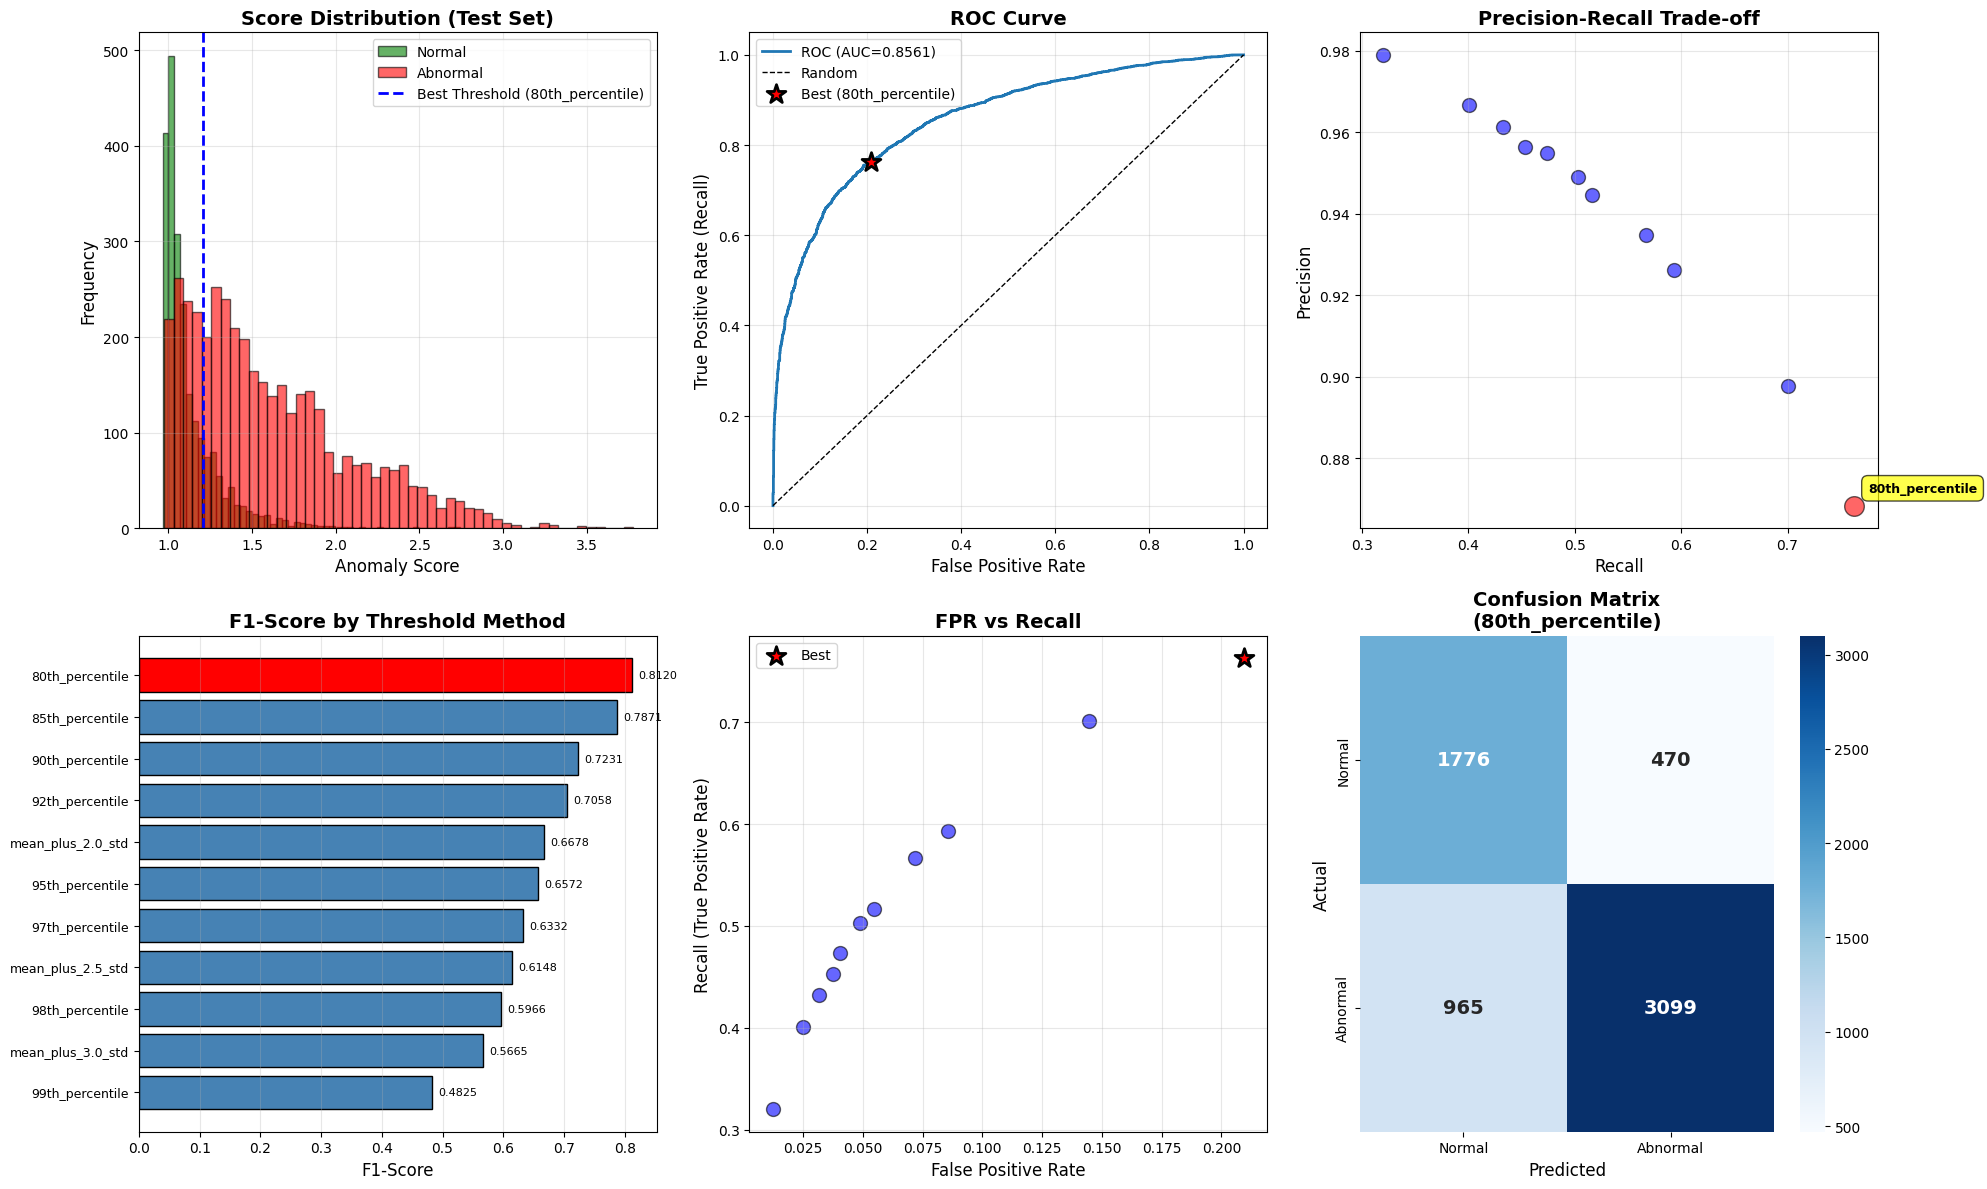

In [ ]:
# === [12] Visualization ===

print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# 한글 폰트 설정 (Colab)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Figure 생성
fig = plt.figure(figsize=(20, 12))

# 1) Score Distribution
ax1 = plt.subplot(2, 3, 1)
ax1.hist(test_norm_scores, bins=50, alpha=0.6, label='Normal', color='green', edgecolor='black')
ax1.hist(test_abn_scores, bins=50, alpha=0.6, label='Abnormal', color='red', edgecolor='black')
ax1.axvline(best_f1['threshold'], color='blue', linestyle='--', linewidth=2, label=f"Best Threshold ({best_f1['method']})")
ax1.set_xlabel('Anomaly Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Score Distribution (Test Set)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2) ROC Curve
ax2 = plt.subplot(2, 3, 2)
fpr_roc, tpr_roc, _ = roc_curve(y_true, y_scores)
ax2.plot(fpr_roc, tpr_roc, linewidth=2, label=f'ROC (AUC={auc:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax2.scatter([best_f1['fpr']], [best_f1['recall']], s=200, c='red', marker='*',
            edgecolors='black', linewidths=2, zorder=5, label=f"Best ({best_f1['method']})")
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate (Recall)', fontsize=12)
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3) Precision-Recall Trade-off
ax3 = plt.subplot(2, 3, 3)
methods = df_results['method'].values
precisions = df_results['precision'].values
recalls = df_results['recall'].values
colors = ['red' if m == best_f1['method'] else 'blue' for m in methods]
sizes = [200 if m == best_f1['method'] else 100 for m in methods]

for i, method in enumerate(methods):
    ax3.scatter(recalls[i], precisions[i], s=sizes[i], c=colors[i], alpha=0.6, edgecolors='black')
    if method == best_f1['method']:
        ax3.annotate(method, (recalls[i], precisions[i]),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax3.set_xlabel('Recall', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4) F1-Score Comparison
ax4 = plt.subplot(2, 3, 4)
sorted_df = df_results.sort_values('f1', ascending=True)
colors_bar = ['red' if m == best_f1['method'] else 'steelblue' for m in sorted_df['method']]
bars = ax4.barh(range(len(sorted_df)), sorted_df['f1'], color=colors_bar, edgecolor='black')
ax4.set_yticks(range(len(sorted_df)))
ax4.set_yticklabels(sorted_df['method'], fontsize=9)
ax4.set_xlabel('F1-Score', fontsize=12)
ax4.set_title('F1-Score by Threshold Method', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 값 표시
for i, (bar, val) in enumerate(zip(bars, sorted_df['f1'])):
    ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=8)

# 5) FPR vs Recall
ax5 = plt.subplot(2, 3, 5)
for i, row in df_results.iterrows():
    if row['method'] == best_f1['method']:
        ax5.scatter(row['fpr'], row['recall'], s=200, c='red', marker='*',
                   edgecolors='black', linewidths=2, zorder=5, label='Best')
    else:
        ax5.scatter(row['fpr'], row['recall'], s=100, c='blue', alpha=0.6, edgecolors='black')

ax5.set_xlabel('False Positive Rate', fontsize=12)
ax5.set_ylabel('Recall (True Positive Rate)', fontsize=12)
ax5.set_title('FPR vs Recall', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# 6) Confusion Matrix (Best Threshold)
ax6 = plt.subplot(2, 3, 6)
cm_best = np.array([[best_f1['tn'], best_f1['fp']],
                    [best_f1['fn'], best_f1['tp']]])
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'],
            ax=ax6, annot_kws={'size': 14, 'weight': 'bold'})
ax6.set_xlabel('Predicted', fontsize=12)
ax6.set_ylabel('Actual', fontsize=12)
ax6.set_title(f'Confusion Matrix\n({best_f1["method"]})', fontsize=14, fontweight='bold')

plt.tight_layout()

# 저장
viz_path = OUTPUT_DIR / "threshold_comparison.png"
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"\n✅ Visualization saved: {viz_path}")

plt.show()


📊 CREATING ADDITIONAL VISUALIZATIONS
✅ Detailed visualization saved: /content/drive/MyDrive/grad_project/output_percentile/fan/threshold_detailed_comparison.png


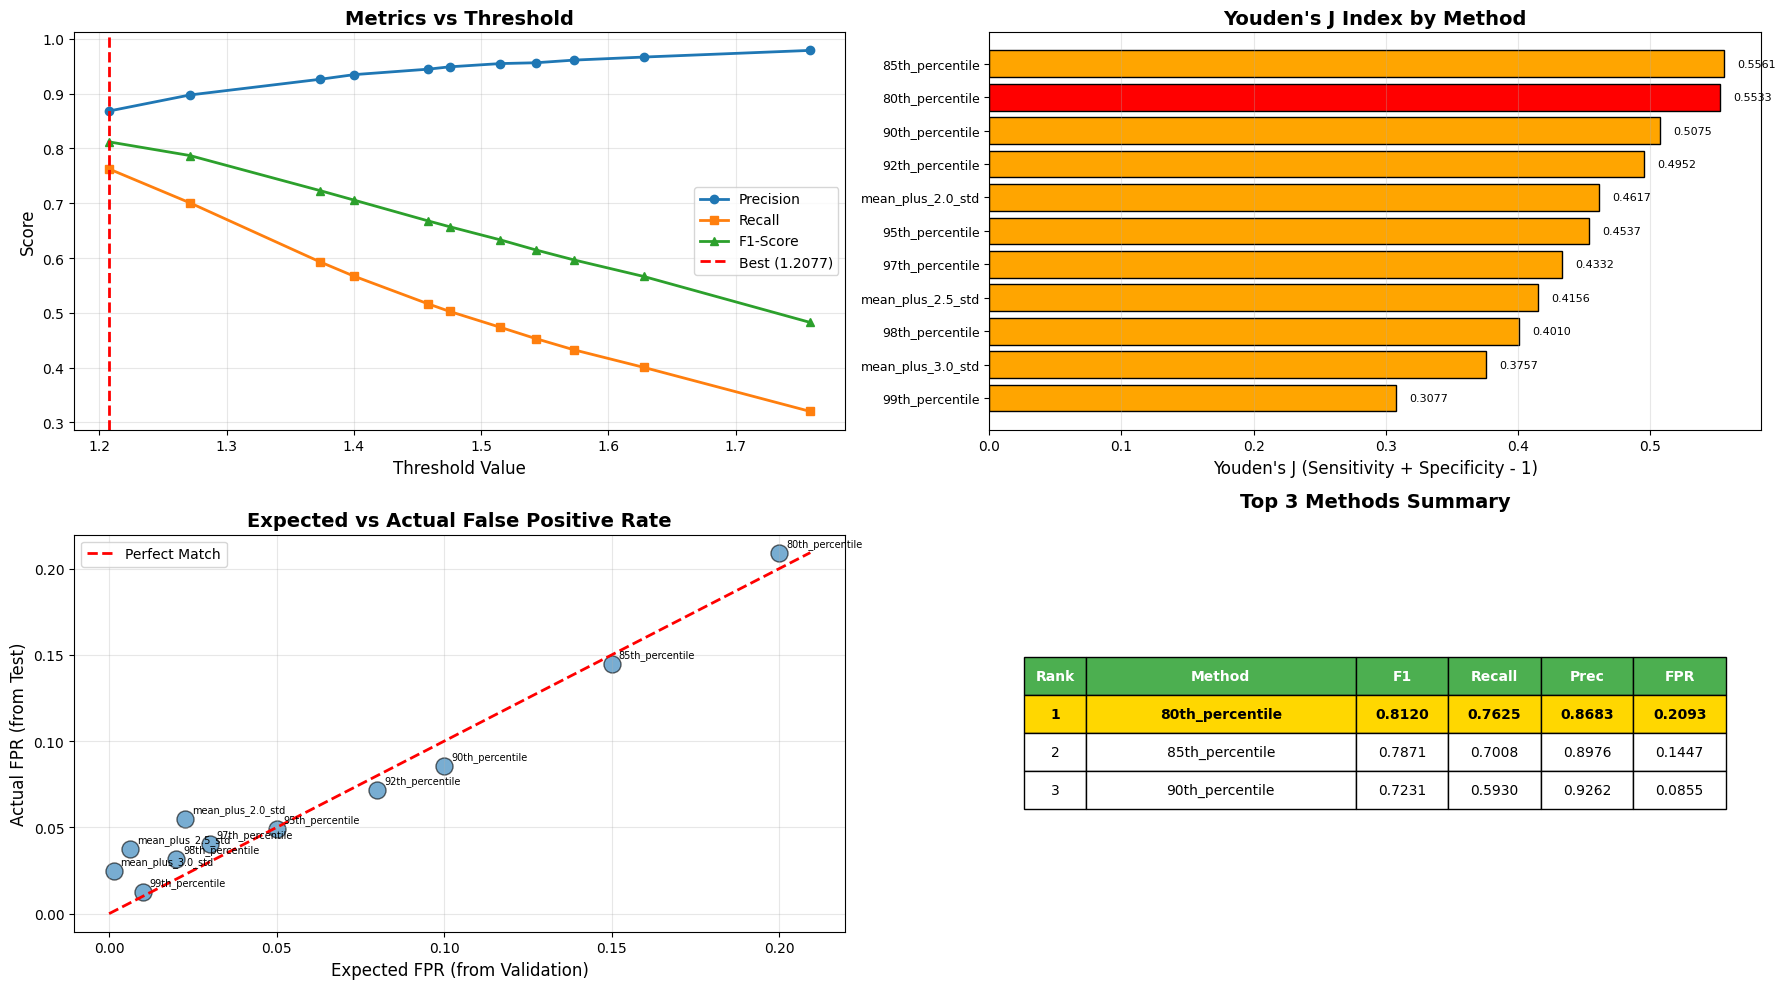

In [ ]:
# === [13] Additional Visualizations ===

print("\n" + "="*60)
print("📊 CREATING ADDITIONAL VISUALIZATIONS")
print("="*60)

# Figure 2: Detailed Comparison
fig2 = plt.figure(figsize=(18, 10))

# 1) Threshold vs Metrics
ax1 = plt.subplot(2, 2, 1)
thresholds_sorted = df_results.sort_values('threshold')
ax1.plot(thresholds_sorted['threshold'], thresholds_sorted['precision'],
         marker='o', label='Precision', linewidth=2)
ax1.plot(thresholds_sorted['threshold'], thresholds_sorted['recall'],
         marker='s', label='Recall', linewidth=2)
ax1.plot(thresholds_sorted['threshold'], thresholds_sorted['f1'],
         marker='^', label='F1-Score', linewidth=2)
ax1.axvline(best_f1['threshold'], color='red', linestyle='--', linewidth=2,
            label=f"Best ({best_f1['threshold']:.4f})")
ax1.set_xlabel('Threshold Value', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2) Youden's J Comparison
ax2 = plt.subplot(2, 2, 2)
sorted_youden = df_results.sort_values('youden_j', ascending=True)
colors_youden = ['red' if m == best_f1['method'] else 'orange' for m in sorted_youden['method']]
bars = ax2.barh(range(len(sorted_youden)), sorted_youden['youden_j'],
                color=colors_youden, edgecolor='black')
ax2.set_yticks(range(len(sorted_youden)))
ax2.set_yticklabels(sorted_youden['method'], fontsize=9)
ax2.set_xlabel("Youden's J (Sensitivity + Specificity - 1)", fontsize=12)
ax2.set_title("Youden's J Index by Method", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, sorted_youden['youden_j'])):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontsize=8)

# 3) Expected FPR vs Actual FPR
ax3 = plt.subplot(2, 2, 3)
expected_fprs = []
actual_fprs = []
method_labels = []

for _, row in df_results.iterrows():
    method = row['method']
    if method in threshold_candidates:
        expected_fpr = threshold_candidates[method].get('expected_fpr', None)
        if expected_fpr is not None:
            expected_fprs.append(expected_fpr)
            actual_fprs.append(row['fpr'])
            method_labels.append(method)

ax3.scatter(expected_fprs, actual_fprs, s=150, alpha=0.6, edgecolors='black')
ax3.plot([0, max(expected_fprs + actual_fprs)],
         [0, max(expected_fprs + actual_fprs)],
         'r--', linewidth=2, label='Perfect Match')

for i, label in enumerate(method_labels):
    ax3.annotate(label, (expected_fprs[i], actual_fprs[i]),
                fontsize=7, xytext=(5, 5), textcoords='offset points')

ax3.set_xlabel('Expected FPR (from Validation)', fontsize=12)
ax3.set_ylabel('Actual FPR (from Test)', fontsize=12)
ax3.set_title('Expected vs Actual False Positive Rate', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4) Performance Summary Table
ax4 = plt.subplot(2, 2, 4)
ax4.axis('off')

# Top 3 methods
top3 = df_results.nlargest(3, 'f1')
table_data = []
table_data.append(['Rank', 'Method', 'F1', 'Recall', 'Prec', 'FPR'])

for idx, (_, row) in enumerate(top3.iterrows(), 1):
    table_data.append([
        str(idx),
        row['method'][:20],  # 길이 제한
        f"{row['f1']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['precision']:.4f}",
        f"{row['fpr']:.4f}"
    ])

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                 colWidths=[0.08, 0.35, 0.12, 0.12, 0.12, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# 헤더 스타일
for i in range(6):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# 1등 강조
for i in range(6):
    table[(1, i)].set_facecolor('#FFD700')
    table[(1, i)].set_text_props(weight='bold')

ax4.set_title('Top 3 Methods Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# 저장
viz2_path = OUTPUT_DIR / "threshold_detailed_comparison.png"
plt.savefig(viz2_path, dpi=300, bbox_inches='tight')
print(f"✅ Detailed visualization saved: {viz2_path}")

plt.show()

In [ ]:
# === [14] Save Results ===

print("\n" + "="*60)
print("💾 SAVING RESULTS")
print("="*60)

# 최종 결과
final_results = {
    "version": "percentile_only",
    "model": "LOF (Local Outlier Factor)",
    "note": "Thresholds based on NORMAL data only (Percentile method)",
    "config": CONFIG,
    "auc": float(auc),
    "cohens_d": float(cohens_d),
    "cohens_d_interpretation": interpretation,
    "best_threshold": {
        "method": best_f1['method'],
        "value": float(best_f1['threshold']),
        "selection_criterion": "Best F1-Score"
    },
    "best_metrics": {
        "accuracy": float(best_f1['accuracy']),
        "precision": float(best_f1['precision']),
        "recall": float(best_f1['recall']),
        "specificity": float(best_f1['specificity']),
        "f1_score": float(best_f1['f1']),
        "fpr": float(best_f1['fpr']),
        "youden_j": float(best_f1['youden_j'])
    },
    "confusion_matrix": {
        "tn": int(best_f1['tn']),
        "fp": int(best_f1['fp']),
        "fn": int(best_f1['fn']),
        "tp": int(best_f1['tp'])
    },
    "all_candidates_performance": df_results.to_dict('records')
}

results_path = OUTPUT_DIR / "final_results.json"
with open(results_path, 'w') as f:
    json.dump(final_results, f, indent=2)
print(f"✅ Results saved: {results_path}")

# CSV 저장
csv_path = OUTPUT_DIR / "threshold_evaluation.csv"
df_results.to_csv(csv_path, index=False)
print(f"✅ CSV saved: {csv_path}")

# Config 저장
config_path = OUTPUT_DIR / "config.json"
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)
print(f"✅ Config saved: {config_path}")

print("\n" + "="*60)


💾 SAVING RESULTS
✅ Results saved: /content/drive/MyDrive/grad_project/output_percentile/fan/final_results.json
✅ CSV saved: /content/drive/MyDrive/grad_project/output_percentile/fan/threshold_evaluation.csv
✅ Config saved: /content/drive/MyDrive/grad_project/output_percentile/fan/config.json

